# Baybayin Classifier

[Dataset source](https://github.com/jmbantay/Baybayin-Handwritten-Character-Dataset)

In [1]:
import os
import random

import tensorflow as tf
import tensorflow.keras as tfk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from PIL import Image
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## The Data

In [2]:
input_shape = (64, 64)
syllables = ["a", "ba", "dara", "ei", "ga", "ha", "ka", "la", "ma", "na", "nga", "ou", "pa", "sa", "ta", "wa", "ya"]

In [3]:
syllable_encoding = {}
for i in range(len(syllables)):
    syllable_encoding[syllables[i]] = i
print(syllable_encoding)

{'a': 0, 'ba': 1, 'dara': 2, 'ei': 3, 'ga': 4, 'ha': 5, 'ka': 6, 'la': 7, 'ma': 8, 'na': 9, 'nga': 10, 'ou': 11, 'pa': 12, 'sa': 13, 'ta': 14, 'wa': 15, 'ya': 16}


In [4]:
def encode_label(label):
    return syllable_encoding[label]

In [5]:
def decode_label(enc):
    return syllables[enc]

### Load the data

In [6]:
def extract_pixels(filename):
    image_pil = Image.open(filename)
    image_np  = np.asarray(image_pil)
    image_res = cv2.resize(image_np,
                           dsize=input_shape,
                           interpolation=cv2.INTER_CUBIC)
    if len(image_res.shape) == 3:
        image_res = cv2.cvtColor(image_res, cv2.COLOR_BGR2GRAY)
    return 1 - image_res / 255.0

In [7]:
def load_images(directory):
    X_raw = []
    Y_raw = []

    for syllable in syllables:
        for filename in os.listdir(directory + '/' + syllable + '/'):
            image_matrix   = extract_pixels(directory + '/' + syllable + '/' + filename)
            label_encoding = encode_label(syllable)
            
            X_raw.append(image_matrix)
            Y_raw.append(label_encoding)
    return X_raw, Y_raw

In [8]:
X_raw, Y_raw = load_images(directory="C:/Users/Franz Cesista/Github/baybayin_lecture/dataset/")

In [9]:
print(len(X_raw))
print(len(Y_raw))

36307
36307


### Data Visualization

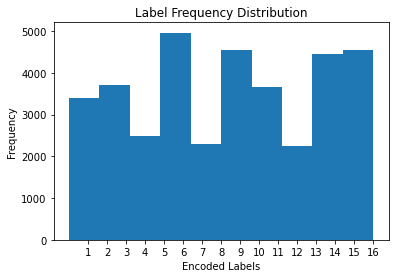

In [10]:
plt.hist(Y_raw)
plt.xticks(range(1, 17))
plt.xlabel("Encoded Labels")
plt.ylabel("Frequency")
plt.title("Label Frequency Distribution")
plt.show()

In [11]:
def display_image(image):
    plt.figure()
    plt.imshow(image, cmap=plt.cm.binary)
    # plt.colorbar()
    plt.grid(False)
    plt.show()

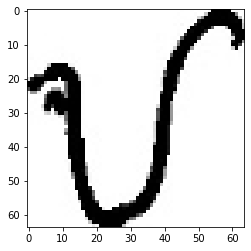

In [12]:
display_image(X_raw[0])

In [13]:
def display_random_images():
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        j = int(np.random.rand() * len(X_raw))
        plt.imshow(X_raw[j], cmap=plt.cm.binary)
        plt.xlabel(decode_label(Y_raw[j]))

    plt.show()

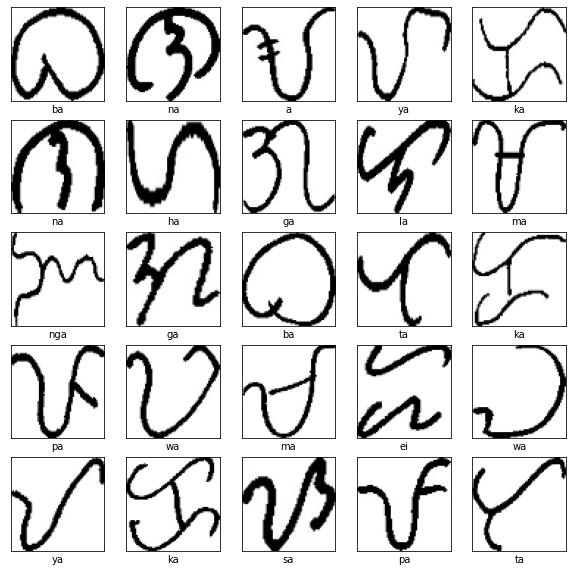

In [14]:
display_random_images()

### Preprocess the data

In [15]:
X_data = np.asarray(X_raw)
Y_data = np.asarray(Y_raw).reshape((-1, 1))

In [16]:
print(X_data.shape)
print(Y_data.shape)

(36307, 64, 64)
(36307, 1)


### One-hot encoding

In [17]:
def one_hot_encoding(data):
    return OneHotEncoder().fit_transform(data).toarray()

def argmax(probability_logits):
    return np.argmax(probability_logits)

In [18]:
Y_data = one_hot_encoding(Y_data)
Y_data.shape

(36307, 17)

### Train-test split

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.20, random_state=0)

## The Model

### Setup the layers

In [20]:
model = tfk.Sequential([
    tfk.layers.Flatten(input_shape=input_shape),
    tfk.layers.Dense(512, activation='relu'),
    tfk.layers.Dense(128, activation='relu'),
    tfk.layers.Dense(32, activation='relu'),
    tfk.layers.Dense(17, activation='softmax'),
])

### Inspect the model

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2097664   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 17)                561       
Total params: 2,168,017
Trainable params: 2,168,017
Non-trainable params: 0
_________________________________________________________________


In [22]:
# tfk.utils.plot_model(model)

### Compile the model

In [23]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [24]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, Y_train,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Train on 23236 samples, validate on 5809 samples
Epoch 1/100
23236/23236 [==============================] - 4s 168us/sample - loss: 0.3667 - accuracy: 0.8919 - val_loss: 0.1810 - val_accuracy: 0.9477
Epoch 2/100
23236/23236 [==============================] - 3s 113us/sample - loss: 0.1216 - accuracy: 0.9656 - val_loss: 0.1579 - val_accuracy: 0.9525
Epoch 3/100
23236/23236 [==============================] - 3s 110us/sample - loss: 0.0754 - accuracy: 0.9788 - val_loss: 0.1268 - val_accuracy: 0.9626
Epoch 4/100
23236/23236 [==============================] - 3s 109us/sample - loss: 0.0536 - accuracy: 0.9839 - val_loss: 0.1592 - val_accuracy: 0.9592
Epoch 5/100
23236/23236 [==============================] - 3s 111us/sample - loss: 0.0531 - accuracy: 0.9836 - val_loss: 0.1600 - val_accuracy: 0.9604
Epoch 6/100
23236/23236 [==============================] - 3s 113us/sample - loss: 0.0381 - accuracy: 0.9887 - val_loss: 0.1520 - val_accuracy: 0.9659
Epoch 7/100
23236/23236 [====================

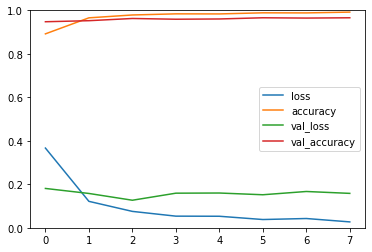

In [25]:
pd.DataFrame(history.history).plot(ylim=(0, 1))

### Evaluate accuracy

In [26]:
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)

print('\nTest accuracy:', test_acc)

7262/7262 - 0s - loss: 0.2023 - accuracy: 0.9598

Test accuracy: 0.9597907


### Save model

In [27]:
model.save('baybayin_model.h5')

### Load model

In [25]:
model = tfk.models.load_model('model.h5')

## Make Predictions

In [96]:
dir = "C:/Users/Franz Cesista/Github/baybayin_lecture/"

In [97]:
def neural_net_prediction(image):
    return model.predict(np.expand_dims(image, axis=0))

def predict(image):
    return decode_label(argmax(neural_net_prediction(image)))

### Example 1

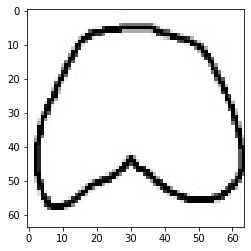

In [98]:
image_matrix = extract_pixels(dir + 'example_1.jpg')
display_image(image_matrix)

In [99]:
predict(image_matrix)

'ba'

### Example 2

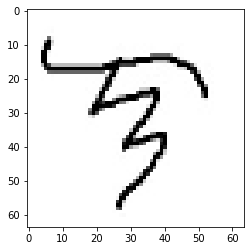

In [100]:
image_matrix = extract_pixels(dir + 'example_2.jpg')
display_image(image_matrix)

In [101]:
predict(image_matrix)

'la'

### Example 3

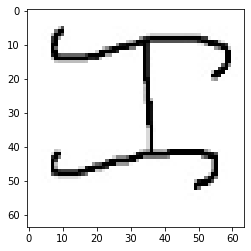

In [102]:
image_matrix = extract_pixels(dir + 'example_3.jpg')
display_image(image_matrix)

In [103]:
predict(image_matrix)

'ka'

### Your drawing

* Open microsoft paint and try to write a baybayin character
* Save to this directory
* Edit the variable `filename` below
* ...
* Profit

In [ ]:
filename = 'your_drawing.jpg'

In [ ]:
image_matrix = extract_pixels(dir + filename)
display_image(image_matrix)

In [ ]:
predict(image_matrix)